In [1]:
!pip install -r ./requirements.txt

# Libraries

In [2]:
!pip install --upgrade datasets
!pip install --upgrade openai

In [3]:
import os
from datasets import Dataset, DatasetDict, Features, Image
import numpy as np
import albumentations as A
import PIL as pil
import matplotlib.pyplot as plt

# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

## Data Loading

In [4]:
def create_data(split_path):
    images = []
    masks = []
    color_dir = os.path.join(split_path, 'color')
    label_dir = os.path.join(split_path, 'label')
    
    # Sort to ensure the pairing order is consistent
    for fname in sorted(os.listdir(color_dir)):
        image_path = os.path.join(color_dir, fname)
        mask_fname = fname.replace("jpg", "png")
        mask_path = os.path.join(label_dir, mask_fname)
        
        images.append(image_path)
        masks.append(mask_path)
        
    return {"image": images, "mask": masks}


In [5]:
features = Features({
    "image": Image(mode="RGB"),
    "mask": Image(mode="RGB")
})

train_val_data = create_data("Dataset/TrainVal")
test_data = create_data("Dataset/Test")

train_val_dataset = Dataset.from_dict(train_val_data, features=features)
test_dataset = Dataset.from_dict(test_data, features=features)


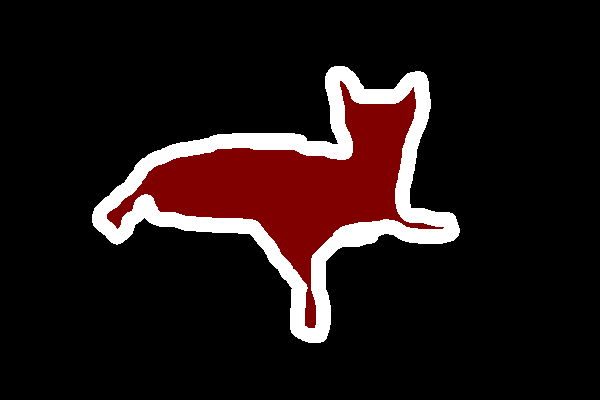

In [6]:
train_val_dataset[0]["mask"]

## Image Augmentations
To prepare for resizing, I will use the smallest width and height image as a baseline for the resized dimensions.

In [7]:
# extract width and height
def extract_dimensions(data):
    width, height = data["image"].size
    return {"width": width, "height": height}

# find min width and height
dim_dataset = train_val_dataset.map(extract_dimensions)
min_w = min(dim_dataset["width"])
min_h = min(dim_dataset["height"])
print((min_h, min_h)) # (108,108)


Map:   0%|          | 0/3680 [00:00<?, ? examples/s]

(108, 108)


In [8]:
const_width = 256
const_height = 256

transform = A.Compose([
    A.Resize(height=min_h, width=min_w),       \
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),                   
    A.ColorJitter(p=0.5),                        
], seed=137, strict=True)
 
resize_transform = A.Resize(height=min_h, width=min_w)


In [9]:
from PIL import Image

def check_and_convert_to_rgb(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image
    
def apply_transform(data):
    image = np.array(data["image"])
    mask = np.array(data["mask"])
    
    # 确保图像是RGB格式
    image = check_and_convert_to_rgb(image)
    
    augmented = augmentation(image=image, mask=mask)
    data["image"] = pil.Image.fromarray(augmented["image"])
    data["mask"] = pil.Image.fromarray(augmented["mask"])
    return data


In [10]:
def get_apply_transform_fn(augmentation):
    def apply_transform(data):
        image = np.array(data["image"])
        mask = np.array(data["mask"])
        augmented = augmentation(image=image, mask=mask)
        data["image"] = pil.Image.fromarray(augmented["image"])
        data["mask"] = pil.Image.fromarray(augmented["mask"])
        return data
    return apply_transform

aug_transform_fn = get_apply_transform_fn(transform)
resize_transform_fn = get_apply_transform_fn(resize_transform)

aug_train_val_dataset = train_val_dataset.map(aug_transform_fn)
resize_train_val_dataset = train_val_dataset.map(resize_transform_fn)


Map:   0%|          | 0/3680 [00:00<?, ? examples/s]

Map:   0%|          | 0/3680 [00:00<?, ? examples/s]

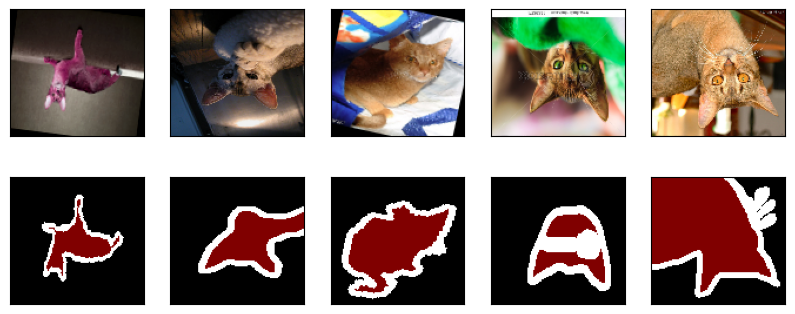

In [11]:
# visualize the transform images
def visualize_transform_images(max, dataset):
    plt.figure(figsize=(10, 4))
    for idx in range(max):
        plt.subplot(2,5,idx+1)
        fig = plt.imshow(dataset[idx]["image"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for idx in range(max):
        plt.subplot(2,5,idx+1+5)
        fig = plt.imshow(dataset[idx]["mask"])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

visualize_transform_images(5, aug_train_val_dataset)

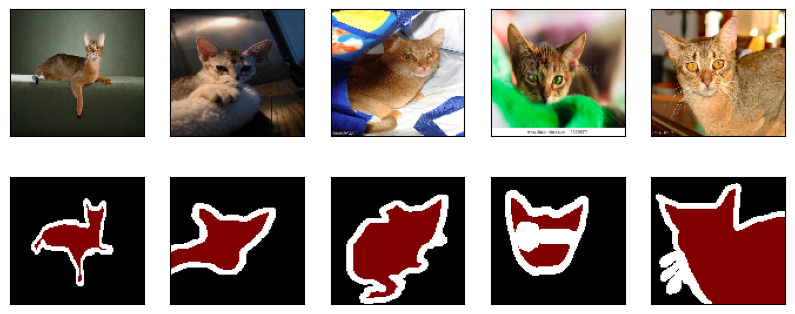

In [12]:
visualize_transform_images(5, resize_train_val_dataset)

In [13]:
save_dir = "Dataset/Augmented_TrainVal"
os.makedirs(save_dir, exist_ok=True)

def apply_transform_and_save(data, idx):
    image = np.array(data["image"])
    mask = np.array(data["mask"])
    augmented = transform(image=image, mask=mask)
    
    image_pil = Image.fromarray(augmented["image"])
    mask_pil = Image.fromarray(augmented["mask"])
    
    image_pil.save(os.path.join(save_dir, f"image_{idx}.jpg"))
    mask_pil.save(os.path.join(save_dir, f"mask_{idx}.png"))

# 遍历数据集，逐个增强并保存
for idx, data in enumerate(train_val_dataset):
    apply_transform_and_save(data, idx)


In [14]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0


In [15]:
!pip install torch torchvision

  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)


In [16]:
pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

def collate_fn(batch):
    """将PIL图像转为Tensor，并进行标准化"""
    images = []
    masks = []
    
    for item in batch:
        # 图像转为Tensor并归一化到[0,1]
        img_tensor = ToTensor()(item["image"])  # [3, H, W]
        images.append(img_tensor)
        
        # 掩码处理：假设是单通道灰度图
        mask_tensor = ToTensor()(item["mask"])  # [1, H, W]
        mask_tensor = mask_tensor.squeeze(0)    # [H, W]
        masks.append(mask_tensor)
    
    return {
        "image": torch.stack(images),  # [B, 3, H, W]
        "mask": torch.stack(masks)     # [B, H, W]
    }

# 创建DataLoader
batch_size = 8
train_loader = DataLoader(
    aug_train_val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    resize_train_val_dataset,  # 验证集不使用增强
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import fcn_resnet50
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [20]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整大小为 (128, 128)，可以根据需求调整
    transforms.ToTensor(),
])

In [21]:
# 定义 U-Net 模型
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # 保持输出尺寸不变，padding=1
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # 保持输出尺寸不变，padding=1
                nn.ReLU(inplace=True)
            )
        
        # 编码器部分
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 下采样层
        
        self.bottleneck = conv_block(512, 1024)  # 最深层的卷积块
        
        # 解码器部分
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # 编码过程
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        # 经过瓶颈层
        b = self.bottleneck(self.pool(e4))
        
        # 解码过程，添加尺寸调整
        d4 = self.decoder4(torch.cat([self.upconv4(b), F.interpolate(e4, size=self.upconv4(b).shape[2:], mode='bilinear', align_corners=False)], dim=1))  # 通过F.interpolate调整e4的尺寸
        d3 = self.decoder3(torch.cat([self.upconv3(d4), F.interpolate(e3, size=self.upconv3(d4).shape[2:], mode='bilinear', align_corners=False)], dim=1))  # 同样调整e3的尺寸
        d2 = self.decoder2(torch.cat([self.upconv2(d3), F.interpolate(e2, size=self.upconv2(d3).shape[2:], mode='bilinear', align_corners=False)], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), F.interpolate(e1, size=self.upconv1(d2).shape[2:], mode='bilinear', align_corners=False)], dim=1))
        
        return self.final_conv(d1)


In [22]:
# 数据集类
class SegmentationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        mask = self.dataset[idx]['mask']
        
        image = self.transform(image)
        mask = torch.tensor(np.array(mask)[:, :, 0], dtype=torch.float32).unsqueeze(0) / 255.0
        return image, mask

In [23]:
# 加载数据
train_dataset = SegmentationDataset(aug_train_val_dataset)
test_dataset = SegmentationDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 初始化模型
model = UNet(in_channels=3, out_channels=1).to("cpu")  # 改为使用 CPU
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
# 训练 U-Net
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to("cpu"), masks.to("cpu")
        
        optimizer.zero_grad()
        outputs = model(images)
        masks_resized = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, masks_resized)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.4692
Epoch 2/10, Loss: 0.4098
Epoch 3/10, Loss: 0.3990
Epoch 4/10, Loss: 0.3876
Epoch 5/10, Loss: 0.3814
Epoch 6/10, Loss: 9.7787
Epoch 7/10, Loss: 0.5013
Epoch 8/10, Loss: 0.4593
Epoch 9/10, Loss: 0.4482
Epoch 10/10, Loss: 0.4451


In [26]:
def evaluate_dice_iou(model, test_dataset, num_samples=5):
    model.eval()
    dice_scores = []
    iou_scores = []
    
    with torch.no_grad():  # 在评估时不计算梯度
        for i, (image, mask) in enumerate(zip(test_dataset['image'], test_dataset['mask'])):
            if i >= num_samples:  # 只处理前 num_samples 张图片
                break
            image_tensor = transform(image).unsqueeze(0)  # 为每张图片添加一个批次维度
            mask_array = np.array(mask)
            mask_tensor = torch.tensor(mask_array[:, :, 0], dtype=torch.float32).unsqueeze(0) / 255.0
            
            # 前向传播并计算输出
            output = model(image_tensor)
            output = torch.sigmoid(output)  # 使用Sigmoid激活
            
            # 二值化输出
            output = output > 0.5
            
            # 计算Dice和IoU
            intersection = torch.sum(output * mask_tensor)
            union = torch.sum(output) + torch.sum(mask_tensor)
            dice_score = 2 * intersection / (torch.sum(output) + torch.sum(mask_tensor))
            iou_score = intersection / union
            
            dice_scores.append(dice_score.item())
            iou_scores.append(iou_score.item())
            
            # 释放内存
            del image_tensor, mask_tensor, output
            torch.cuda.empty_cache()  # 如果使用GPU
            
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

In [ ]:
# 假设模型已训练并加载
evaluate_dice_iou(model, test_dataset)